# Image Preprocessing 

In this notebook, we will be pulling datasets from `HuggingFaceHub`, preprocessing them and then storing them in `.npz` files. 

In [2]:
from datasets import load_dataset

train_dataset = load_dataset("Az-r-ow/chest_xray", split="train")

In [3]:
from PIL import Image
from io import BytesIO

labels = train_dataset.features["label"].names


def format_dataset(dataset):
    pd_dataset = dataset.to_pandas()
    pd_dataset["true_label"] = pd_dataset["label"].map(lambda x: labels[x])
    pd_dataset["image"] = pd_dataset["image"].map(
        lambda i: Image.open(BytesIO(i["bytes"]))
    )
    return pd_dataset


# Converting to pandas will encode the images to bytestrings
train_data = format_dataset(train_dataset)
train_data.head()

,image,label,true_label
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL


In [30]:
import cv2
import numpy as np

def get_contours(img, heatmap):
  grayscale = img.convert("L")
  resized_image = grayscale.resize((100, 100))
  resized_image = np.array(resized_image)
  ret, thresh = cv2.threshold(resized_image, 150, 255, cv2.THRESH_BINARY)
  contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
  for contour in contours:
    for point in contour:
      x, y = point[0]
      heatmap[y, x] += 1

In [31]:
heatmap = np.zeros((100, 100), dtype=np.float32)

contours = train_data["image"].map(lambda x: get_contours(x, heatmap)).reset_index(drop=True)


[[ 78  89  64 ... 114 163 212]
 [105 138 125 ... 147 146  62]
 [100 225 193 ... 141 143  74]
 ...
 [ 68  27  37 ...  39  23 105]
 [ 73  30  45 ...  35  27 117]
 [ 65  68  91 ...  80  78  95]]


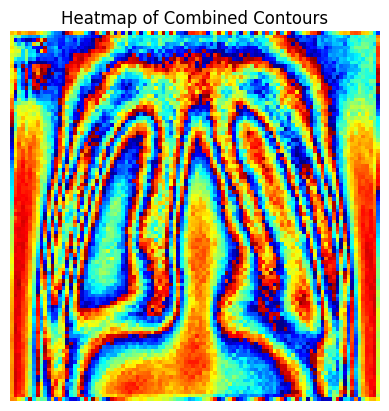

In [34]:
from matplotlib import pyplot as plt

print(heatmap)

heatmap = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)

# Convert heatmap to uint8 for visualization
heatmap = heatmap.astype(np.uint8)

# Apply a color map to the heatmap
heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Display the heatmap
plt.imshow(heatmap_colored)
plt.title('Heatmap of Combined Contours')
plt.axis('off')
plt.show()

